## Bayesian Meta-Optimization

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/MetaOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsl1877BS8m3yt8t_wq2IWji)

## Introduction

Heuristic optimizers such as Genetic Algorithms (GA), Particle Swarm Optimization (PSO) and Differential Evolution (DE) all have a number of parameters that may greatly influence their performance and ability to optimize any given problem. Setting these parameters is somewhat of a *black art* because the inner workings of these optimizers are still very poorly understood. Often the best parameters are counter-intuitive and a choice of parameters that is good for one problem may be almost useless for another problem.

Here we present a new method for automatic tuning of the parameters of a heuristic optimizer. This is often called [Meta-Optimization](https://en.wikipedia.org/wiki/Meta-optimization) which is an idea that is closely related to [Hyper-Parameter Optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization). The method presented here is quite sophisticated and would take considerable effort to implement from scratch. Fortunately we can build the entire system very quickly with just a few lines of source-code by using two existing Python packages.

## Flowchart

We use a so-called [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) to approximate how different parameters affect the performance of the heuristic optimizer on a benchmark problem. We then use a form of so-called [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) to find the set of parameters that most likely improve upon the optimizer's performance. These parameters are then tried and the result is used to improve the accuracy of the Gaussian Process. This is repeated until a good set of parameters has been found for the optimizer.

![Flowchart](images/01_flowchart_bayesian_optimization.png)

## Imports

In [1]:
# Normal packages.
import numpy as np

# Heuristic optimizers such as DE and PSO.
# This is actually implemented in C++ so it should run very fast.
import pygmo as pg

# Bayesian optimization.
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective

/home/magnus/anaconda3/envs/metaops/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pg.__version__

'2.8'

In [3]:
skopt.__version__

'0.5.2'

## Problem

In this example, the problem that we ultimately want to optimize is the [Rosenbrock](https://en.wikipedia.org/wiki/Rosenbrock_function) benchmark problem in 100 dimensions. You could replace this with your own problem, see the [pygmo manual](https://esa.github.io/pagmo2/docs/python/tutorials/python_tut.html) for instructions.

In [4]:
# Create an instance of the problem we want to optimize.
problem = pg.problem(pg.rosenbrock(dim=100))

In [5]:
# Initialize the best-found solution and associated fitness.
# This will be updated after each optimization run.
best_x = None
best_fitness = float('inf')

In [6]:
# Max number of problem evaluations allowed in a single
# optimization run.
num_fitness_evals = 100000

In [7]:
# Number of optimization runs to perform for each new choice
# of parameters for the optimizer. This should not be too low
# because the optimizer is stochastic. Even though the Bayesian
# Optimizer can handle this, it seems to be better to average
# the performance over several runs. It should also not be too high.
num_runs = 20

## Optimizer Parameters

In this example, we will use [Differential Evolution (DE)](https://en.wikipedia.org/wiki/Differential_evolution) as the heuristic optimizer whose parameters we want to tune. We first need to setup the search-space dimensions for the parameters.

In [8]:
# Parameter-dimension for population size.
dim_pop_size = Integer(name="pop_size", low=5, high=200)

# Parameter-dimension for F (differential weight).
dim_F = Real(name="F", low=0.0, high=1.0)

# Parameter-dimension for CR (crossover probability).
dim_CR = Real(name="CR", low=0.0, high=1.0)

# Parameter-dimension for DE optimizer variant.
dim_variant = Integer(name="variant", low=1, high=10)

In [9]:
# List of all parameter-dimensions.
dimensions  = [dim_pop_size, dim_F, dim_CR, dim_variant]

In [10]:
# Names for the parameters.
# This is needed in the plotting functions because the API of
# scikit-optimize is poorly designed in places.
dimension_names = ["pop_size", "F", "CR", "variant"]

In [11]:
# A default choice of parameters.
default_parameters = [100, 0.8, 0.9, 2]

In [12]:
# Names of the optimizer variants used for printing.
variant_names = \
{
     1: "best/1/exp",
     2: "rand/1/exp",
     3: "rand-to-best/1/exp",
     4: "best/2/exp",
     5: "rand/2/exp",
     6: "best/1/bin",
     7: "rand/1/bin",
     8: "rand-to-best/1/bin",
     9: "best/2/bin",
     10: "rand/2/bin"    
}

## Meta-Fitness

This is the so-called Meta-Fitness function that takes a set of parameters for the heuristic optimizer and evaluates their performance on the benchmark problem.

In [13]:
@use_named_args(dimensions=dimensions)
def meta_fitness(pop_size, CR, F, variant):
    """
    Meta-fitness for evaluating the performance of the
    optimizer on one or more problems.

    :param pop_size: Population size.
    :param CR: Control-parameter CR (crossover probability).
    :param F: Control-parameter F (differential weight).
    :param variant: DE variant, integer between 1 and 10.
    :return: Float to be minimized.
    """

    # Type-cast from int64 to int because pygmo requires that.
    pop_size = int(pop_size)
    variant = int(variant)

    # Print parameters.
    print("pop_size:", pop_size)
    print("CR: {0:.2f}".format(CR))
    print("F: {0:.2f}".format(F))
    print("variant: {0} ({1})".format(variant,
                                      variant_names[variant]))
    
    # Number of iterations for the optimizer's population.
    # This ensures that we perform the same number of
    # evaluations of the problem's fitness function
    # regardless of the population-size.
    num_generations = num_fitness_evals // pop_size

    def _run():
        """
        Helper-function for performing a single optimization run.
        """

        # Create a new instance of the optimizer using
        # the given parameters.
        uda = pg.de(gen=num_generations, CR=CR, F=F, variant=variant)
        optimizer = pg.algorithm(uda=uda)

        # Create a population of agents for the optimizer.
        pop = pg.population(problem, size=pop_size)

        # Evolve the optimizer's population.
        pop = optimizer.evolve(pop)
        
        # Best fitness found in this optimization run.
        fitness = pop.champion_f[0]
        
        # Update the global variables for best-found solution.
        global best_fitness, best_x
        if fitness < best_fitness:
            best_fitness = fitness
            best_x = np.copy(pop.champion_x)
        
        return fitness
    
    # Perform a number of optimization runs and get a list
    # of the best fitness-values found in those runs.
    fitnesses = np.array([_run() for i in range(num_runs)])

    # The meta-fitness is the mean of those fitness-values.
    meta_fitness = fitnesses.mean()
    
    # Print the meta-fitness.
    print("meta_fitness: {0:.2e}".format(meta_fitness))
    print()
    
    return meta_fitness

In [14]:
# Test the function on the default parameters.
meta_fitness(default_parameters)

pop_size: 100
CR: 0.90
F: 0.80
variant: 2 (rand/1/exp)
meta_fitness: 4.87e+03



4868.149167824088

## Meta-Optimization

Now we can run the Meta-Optimization to find the best parameters for the heuristic optimizer, as well as the best solution for the actual problem we are interested in solving.

In [15]:
%%time
search_result = gp_minimize(func=meta_fitness,
                            dimensions=dimensions,
                            n_calls=50,
                            acq_func='EI', # Expected Improvement.
                            x0=default_parameters)

pop_size: 100
CR: 0.90
F: 0.80
variant: 2 (rand/1/exp)
meta_fitness: 4.66e+03

pop_size: 196
CR: 0.24
F: 0.22
variant: 9 (best/2/bin)
meta_fitness: 4.71e+03

pop_size: 37
CR: 0.69
F: 0.41
variant: 3 (rand-to-best/1/exp)
meta_fitness: 8.88e+01

pop_size: 98
CR: 0.27
F: 0.20
variant: 7 (rand/1/bin)
meta_fitness: 1.89e+02

pop_size: 46
CR: 0.91
F: 0.24
variant: 6 (best/1/bin)
meta_fitness: 2.71e+06

pop_size: 156
CR: 0.55
F: 0.10
variant: 5 (rand/2/exp)
meta_fitness: 6.84e+02

pop_size: 17
CR: 0.50
F: 0.85
variant: 4 (best/2/exp)
meta_fitness: 1.01e+02

pop_size: 87
CR: 0.87
F: 0.43
variant: 7 (rand/1/bin)
meta_fitness: 2.86e+02

pop_size: 34
CR: 0.06
F: 0.90
variant: 4 (best/2/exp)
meta_fitness: 4.22e+02

pop_size: 145
CR: 0.00
F: 0.56
variant: 1 (best/1/exp)
meta_fitness: 4.64e+03

pop_size: 123
CR: 0.54
F: 0.34
variant: 6 (best/1/bin)
meta_fitness: 2.39e+05

pop_size: 11
CR: 0.76
F: 0.04
variant: 5 (rand/2/exp)
meta_fitness: 1.69e+05

pop_size: 135
CR: 0.35
F: 0.97
variant: 1 (best/1/e

## Results

We can now show several results of the Meta-Optimization.

In [16]:
# This is the best fitness value for the actual problem we
# were trying to optimize, in this case the Rosenbrock problem.
best_fitness

0.7157490455691291

In [17]:
# Best solution for the Rosenbrock problem.
best_x

array([0.9939679 , 0.99406711, 0.99407582, 0.99115199, 0.99275279,
       0.9912751 , 0.99081977, 0.99145648, 0.99210012, 0.99319021,
       0.99160839, 0.99397586, 0.99511176, 0.99382332, 0.99446491,
       0.993103  , 0.9949504 , 0.99569109, 0.99428724, 0.99295317,
       0.99407859, 0.99491388, 0.99511708, 0.99250253, 0.9921781 ,
       0.99014079, 0.99293716, 0.99278222, 0.99522344, 0.99547432,
       0.99691571, 0.99738423, 0.99694656, 0.99655378, 0.99716768,
       0.99667813, 0.99742076, 0.99741898, 0.99604799, 0.99500783,
       0.99707729, 0.99878386, 0.99983031, 1.00036703, 1.00026111,
       1.00014392, 1.00009761, 0.99933234, 0.99840288, 0.99654709,
       0.99657004, 0.99697644, 0.99735727, 0.99708081, 0.99659092,
       0.99536468, 0.99713337, 0.99840613, 0.99804402, 0.99764227,
       0.99572776, 0.99097023, 0.99213882, 0.98989369, 0.98783372,
       0.99139423, 0.99012756, 0.98532272, 0.97923349, 0.9813734 ,
       0.97491246, 0.9824034 , 0.99182786, 0.98992701, 0.98820

In [18]:
# Best parameters found for the heuristic optimizer.
# These are useful if you want to run the optimizer again
# on similar problems, without needing to tune it again.
# You can also try and run the optimizer e.g. 100 times
# using these parameters to see if you can improve upon
# best_x and best_fitness for the actual problem.
best_parameters = search_result.x
best_parameters

[10, 0.6924273767128258, 0.004773916775181576, 3]

In [19]:
# Show all the parameters that were tried during meta-optimization.
# Can you spot a trend here? Do some parameters generally work better?
for meta_fit, params in sorted(zip(search_result.func_vals, search_result.x_iters)):
    msg = "Meta-fitness: {0:.2e}, Parameters: {1}"
    print(msg.format(meta_fit, list(np.around(params, 2))))

Meta-fitness: 2.31e+01, Parameters: [10.0, 0.69, 0.0, 3.0]
Meta-fitness: 8.88e+01, Parameters: [37.0, 0.41, 0.69, 3.0]
Meta-fitness: 9.18e+01, Parameters: [15.0, 0.72, 0.67, 4.0]
Meta-fitness: 9.44e+01, Parameters: [35.0, 0.63, 0.71, 4.0]
Meta-fitness: 9.46e+01, Parameters: [38.0, 0.41, 0.65, 5.0]
Meta-fitness: 1.01e+02, Parameters: [17.0, 0.85, 0.5, 4.0]
Meta-fitness: 1.15e+02, Parameters: [64.0, 0.28, 0.63, 4.0]
Meta-fitness: 1.22e+02, Parameters: [88.0, 0.7, 0.7, 3.0]
Meta-fitness: 1.31e+02, Parameters: [8.0, 0.93, 0.11, 1.0]
Meta-fitness: 1.48e+02, Parameters: [7.0, 0.78, 0.28, 3.0]
Meta-fitness: 1.69e+02, Parameters: [196.0, 0.59, 0.96, 1.0]
Meta-fitness: 1.89e+02, Parameters: [98.0, 0.2, 0.27, 7.0]
Meta-fitness: 2.24e+02, Parameters: [62.0, 0.47, 0.79, 9.0]
Meta-fitness: 2.53e+02, Parameters: [188.0, 0.21, 0.82, 2.0]
Meta-fitness: 2.84e+02, Parameters: [193.0, 0.38, 0.78, 1.0]
Meta-fitness: 2.86e+02, Parameters: [87.0, 0.43, 0.87, 7.0]
Meta-fitness: 3.33e+02, Parameters: [24.0, 0

### Plots

We can also plot the progress of the Meta-Optimization by showing the best-found Meta-Fitness after each step.

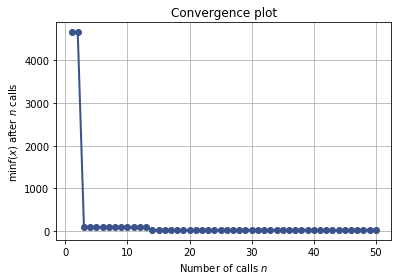

In [20]:
plot_convergence(search_result)

The following plot is more complicated and requires some explanation.

The Bayesian optimizer works by building a surrogate model of the search-space and then searching this model instead of the real search-space, because it is much faster. The following plot shows the last surrogate model built by the Bayesian optimizer where yellow regions are better and blue regions are worse. The black dots show where the optimizer has sampled the search-space and the red dot shows the best parameters found.

Several things should be noted here. Firstly, this surrogate model of the search-space may not be accurate. It is built from only a small number of calls to the `meta_fitness()` function. The modelled meta-fitness landscape may differ significantly from its true values especially in regions of the search-space with few samples. Secondly, the plot may change each time the meta-optimization is run because of random noise. Thirdly, each sub-plot shows the effect of changing two parameters such as `pop_size` and `CR` when averaged over all other dimensions in the search-space, this is also called a Partial Dependence plot and is a way of visualizing high-dimensional spaces in only 2-dimensions.

We now make a matrix-plot of all combinations of these dimensions. 

The diagonal shows the influence of a single dimension on the meta-fitness. This is a so-called Partial Dependence plot for that dimension. It shows how the approximated meta-fitness value changes with different values in that dimension.

The plots below the diagonal show the Partial Dependence for two dimensions. This shows how the approximated meta-fitness value changes when we are varying two dimensions simultaneously.

These Partial Dependence plots are only approximations of the modelled meta-fitness function - which in turn is only an approximation of the true meta-fitness function in `meta_fitness()`. This may be a bit difficult to understand. For example, in the first diagonal plot on the top, the Partial Dependence is calculated by fixing one value for the `pop_size` and then taking a large number of random samples for the remaining dimensions in the search-space. The estimated fitness for all these points is then averaged. This process is then repeated for other values of the `pop_size` to show how it affects the meta-fitness on average. A similar procedure is done for the plots that show the Partial Dependence plots for two dimensions.

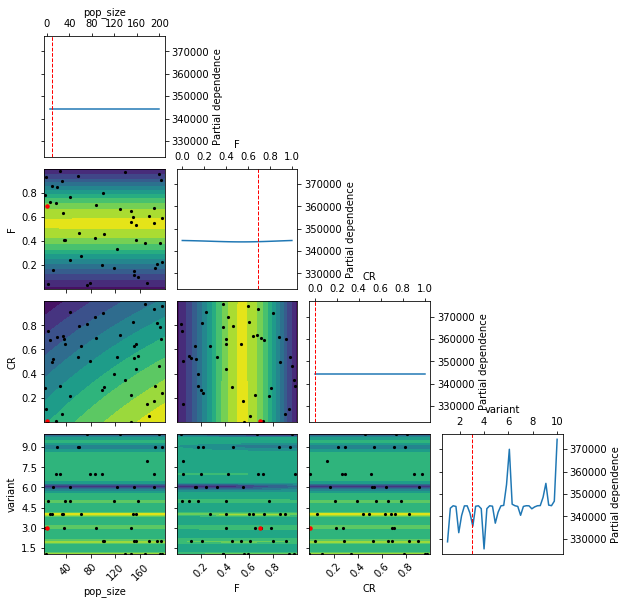

In [21]:
_ = plot_objective(result=search_result, dimensions=dimension_names)

## Conclusion

We presented a method for automatically tuning the parameters of a heuristic optimizer. The method is fairly sophisticated but when combining existing Python libraries, it is very easy to implement.

The method is mainly useful in two scenarios:

1. If the default parameters for the heuristic optimizer do not work very well on your particular problem, and you can afford to run the optimizer many times to try different parameters. Then you can use this method to automatically find good parameters for the optimizer, as well as a better solution to the actual problem you are trying to optimize.

2. If you need to run the heuristic optimizer many times on problems that are somewhat related, then you can use Meta-Optimization to find a good choice of parameters that makes the optimizer perform well on those problems.

## Exercises & Research Ideas

There are plenty of opportunities for doing original research using these techniques. Here are some ideas to get you started:

- Try using other benchmark problems as well as real-world problems. Record the results. Are there parameters that seem to work well for all problems?
- Try using multiple problems inside the `meta_fitness()` function. First try and optimize each problem in turn and merely sum the results to an aggregate meta-fitness. What is the problem with that approach and can you find a better solution?
- Try running more iterations of the meta-optimizer. Does that improve the results?
- Use another Bayesian optimizer, see the [docs](https://scikit-optimize.github.io/#header-functions) for a list.
- Use another acquisition function for the Bayesian optimizer.
- Tune the parameters of another optimizer such as Particle Swarm Optimization (PSO) or Genetic Algorithm (GA).
- Can you eliminate some of the optimizer's parameters if they are irrelevant? Can you simplify the algorithm as a result? How does it perform on a broad range of problems?

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.